# AlexNet

In [1]:
import numpy as np

from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

import torch.nn as nn # Defines a series of classes to implement neural nets
import torch.nn.functional as F # Contains functions that are used in network layers

from torchvision import datasets, transforms


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
torch.backends.cudnn.benchmark = True

---
## Load CIFAR-10

Classes represented in the dataset:

* Airplane
* Automobile
* Bird
* Cat
* Deer
* Dog
* Frog
* Horse
* Ship
* Truck


In [4]:
def load_dataset(batch_size :int = 64, data_dir: str = './'):
    
    train_transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                         ]
                                        )
    
    test_transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                                        ]
                                       )
    

    train_dataset = datasets.CIFAR10(root=data_dir,
                                     train=True,
                                     download=True,
                                     transform=train_transform)
    
    test_dataset = datasets.CIFAR10(root=data_dir,
                                     train=False,
                                     download=True,
                                     transform=test_transform)
    
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader

In [5]:
train_loader, test_loader = load_dataset(data_dir = '../Data')

Files already downloaded and verified
Files already downloaded and verified


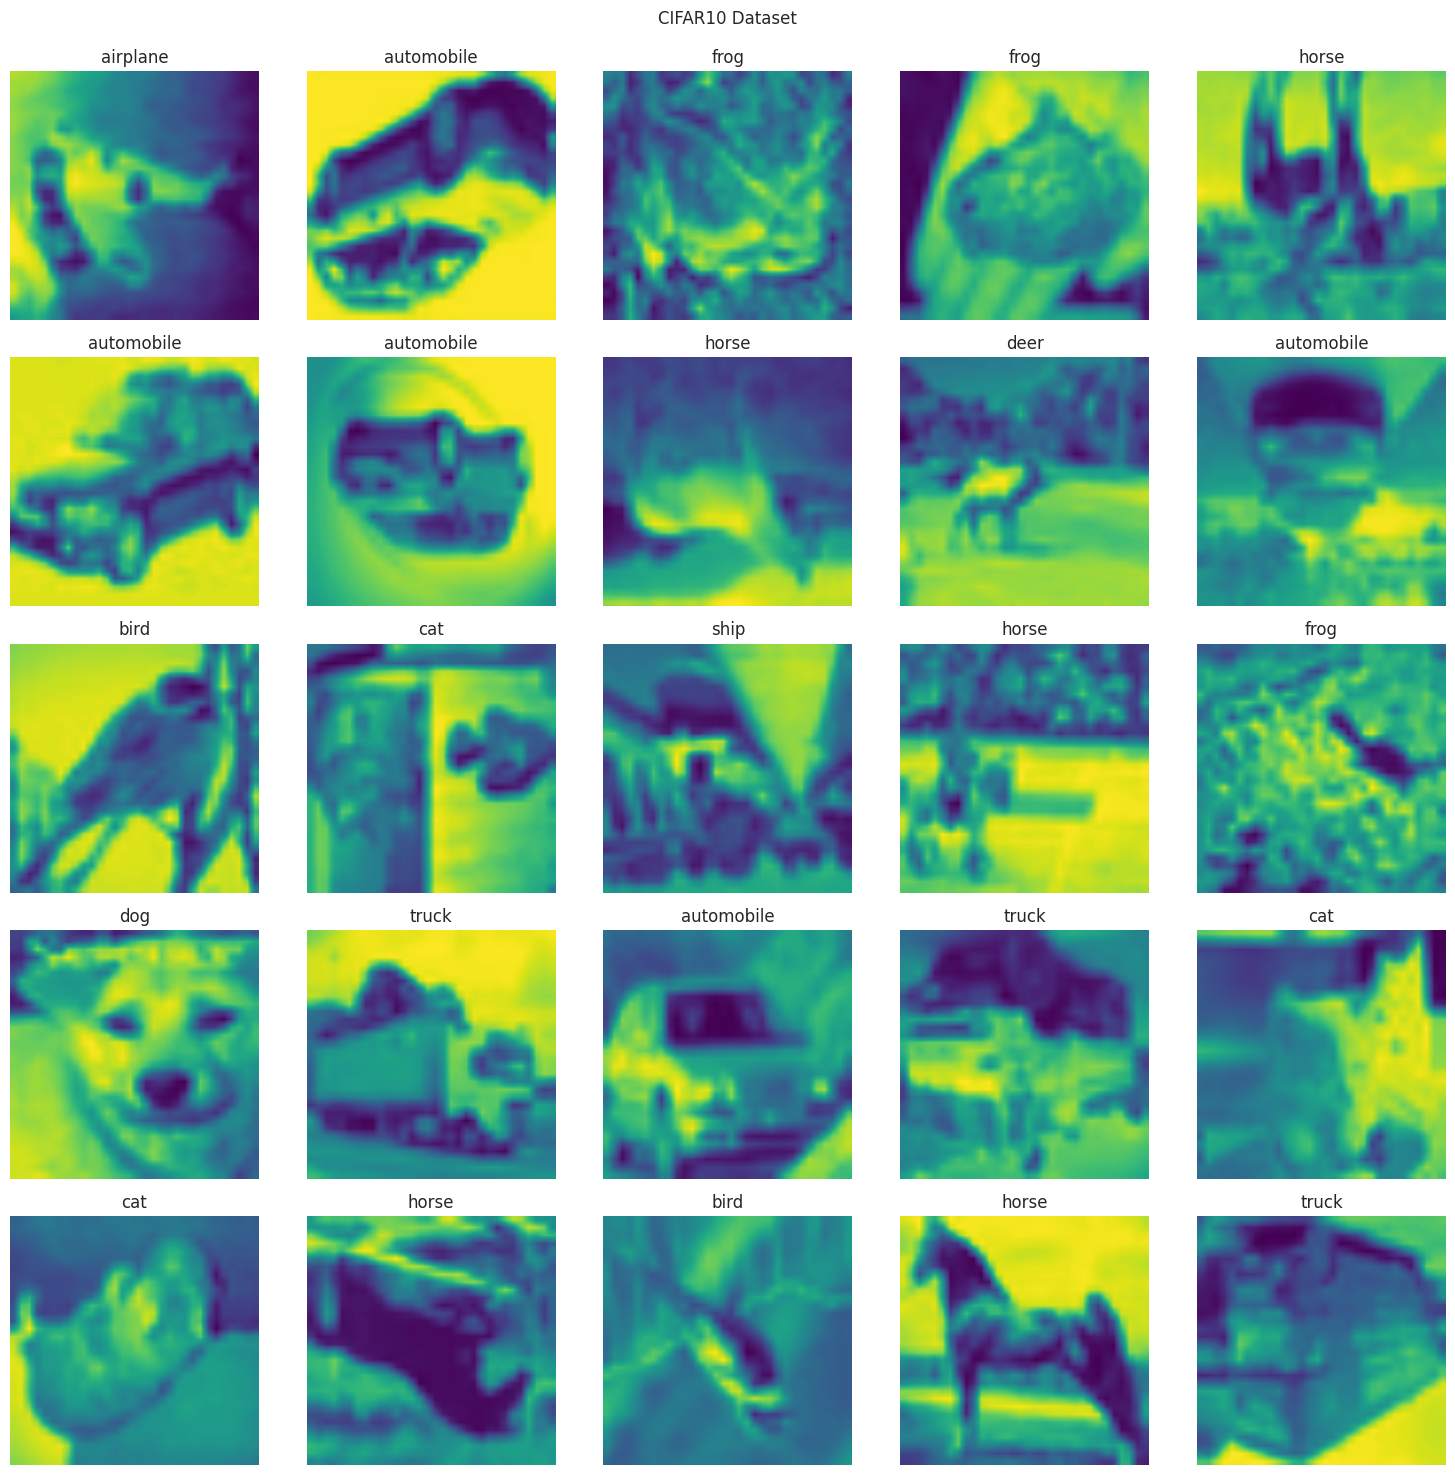

In [6]:
def show_batch(data: DataLoader, mapping_dict: dict, num_rows: int =5) -> None:
    
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_rows, figsize=(15, 15))
    
    batch = next(iter(data))
    images, labels = batch[0], batch[1]
    current_label = 0
    for row in range(num_rows):
        for column in range(num_rows):
            ax[row, column].imshow(images[num_rows*row + column][0, :, :], cmap='viridis')
            ax[row, column].axis('off')
            
            ax[row, column].set_title(mapping_dict[int(labels[current_label].numpy())])
            current_label += 1
            
    plt.suptitle("CIFAR10 Dataset\n")
    plt.tight_layout()
    plt.show()
    
    
id2class = {0:'airplane',
            1:'automobile',
            2:'bird',
            3:'cat',
            4:'deer',
            5:'dog',
            6:'frog',
            7:'horse',
            8:'ship',
            9:'truck'}

show_batch(train_loader, mapping_dict=id2class)

---
## Model Architecture

In [9]:
class ConvBlock(nn.Module):
    def __init__(self,
                   in_channels:int,
                   out_channels:int,
                   kernel_size:int,
                   stride:int,
                   padding:int,
                   use_max_pool: bool = True,
                   max_pool_kernel_size:int = 3,
                   max_pool_stride:int = 2,
                   ):
        
        super(ConvBlock, self).__init__()
        
        self.__use_max_pool = use_max_pool
        
        
        if self.__use_max_pool:
            self.block = nn.Sequential(
                        nn.Conv2d(in_channels=in_channels,
                                  out_channels=out_channels,
                                  kernel_size=kernel_size,
                                  stride=stride,
                                  padding=padding),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=max_pool_kernel_size, stride=max_pool_stride)
                    )
        else:
            self.block = nn.Sequential(
                                nn.Conv2d(in_channels=in_channels,
                                          out_channels=out_channels,
                                          kernel_size=kernel_size,
                                          stride=stride,
                                          padding=padding),
                                nn.BatchNorm2d(out_channels),
                                nn.ReLU()
                            )
              
    
    def forward(self, x):            
        return self.block(x)
        

In [10]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        
        self.block1 = ConvBlock(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0, max_pool_kernel_size=3, max_pool_stride=2)
        self.block2 = ConvBlock(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2, max_pool_kernel_size=3, max_pool_stride=2)
        self.block3 = ConvBlock(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1, use_max_pool=False)
        self.block4 = ConvBlock(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1, use_max_pool=False)
        self.block5 = ConvBlock(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1, max_pool_kernel_size=3, max_pool_stride=2)
        
        
        self.fc = nn.Sequential(
            nn.Linear(in_features=6400, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes)
        )
        
        
    def forward(self, x):
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        
        x = x.reshape(x.size(0), -1)
        
        return self.fc(x)
        

In [11]:
alexnet = AlexNet(num_classes=10)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
alexnet = alexnet.to(device)

Device: cuda


In [14]:
from torchinfo import summary

summary(model=alexnet, input_size=(1, 3, 224, 224), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AlexNet (AlexNet)                        [1, 3, 224, 224]     [1, 10]              --                   True
├─ConvBlock (block1)                     [1, 3, 224, 224]     [1, 96, 26, 26]      --                   True
│    └─Sequential (block)                [1, 3, 224, 224]     [1, 96, 26, 26]      --                   True
│    │    └─Conv2d (0)                   [1, 3, 224, 224]     [1, 96, 54, 54]      34,944               True
│    │    └─BatchNorm2d (1)              [1, 96, 54, 54]      [1, 96, 54, 54]      192                  True
│    │    └─ReLU (2)                     [1, 96, 54, 54]      [1, 96, 54, 54]      --                   --
│    │    └─MaxPool2d (3)                [1, 96, 54, 54]      [1, 96, 26, 26]      --                   --
├─ConvBlock (block2)                     [1, 96, 26, 26]      [1, 256, 12, 12]     --                   True
│    └─Sequential 

---
## Model training

In [20]:
def training_setup(learning_rate, model):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    return loss, optimizer


loss_module, optimizer = training_setup(learning_rate=1e-3,
                                                  model=alexnet)

In [21]:
def train(model,
          num_epochs,
          device,
          loss_module,
          optimizer,
          train_loader):
    
    total_steps = len(train_loader)
    
    history = []
    
    for epoch in tqdm(range(num_epochs)):
        
        train_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            
            model.train()
            
            images = images.to(device)
            labels = labels.to(device)
            
            preds = model(images)
            loss = loss_module(preds, labels)
            
            train_loss += loss.item()
            
            #Backward and Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        train_loss /= len(train_loader)
            
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss}")
                
        history.append(train_loss)
        
    sns.lineplot(history).set_title('Loss vs Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
        
    return history

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5] - Train Loss: 1.6922001619168254
Epoch [2/5] - Train Loss: 1.324491087280576
Epoch [3/5] - Train Loss: 1.1239985851070764
Epoch [4/5] - Train Loss: 0.9922127913483574
Epoch [5/5] - Train Loss: 0.8986089074093363


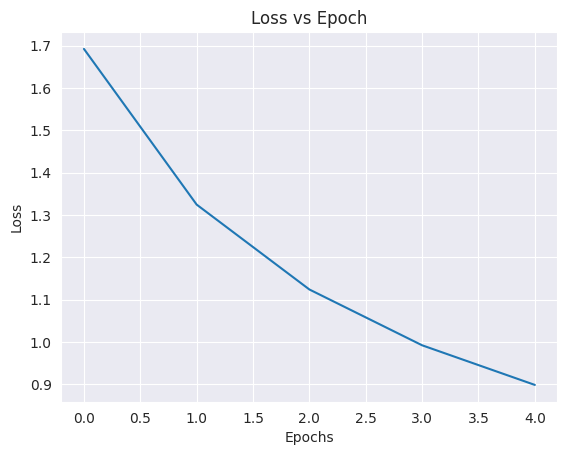

In [22]:
history = train(model=alexnet,
                  num_epochs=5,
                  device=device,
                  loss_module=loss_module,
                  optimizer=optimizer,
                  train_loader=train_loader)

---
## Test metrics

In [23]:
from torchmetrics import Accuracy

test_loss, test_acc = 0, 0

alexnet.to(device)

accuracy = Accuracy(task='multiclass', num_classes=10)
accuracy.to(device)

alexnet.eval()

with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = alexnet(X)
        
        test_loss += loss_module(y_pred, y)
        test_acc += accuracy(y_pred, y)
        
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

Test loss:  0.94158| Test acc:  0.67148
